In [1]:
import tensorflow as tf
from tensorflow.contrib import eager as tfe
import numpy as np
from matplotlib import pylab as plt
from scipy import io as sio
from sklearn import metrics

%matplotlib inline

tf.enable_eager_execution()

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [50]:
X_train = mat.get('X')
X_val = mat.get('Xval')
Y_val = mat.get('yval')

X_train.shape, X_val.shape, Y_val.shape, Y_val.sum()

((307, 2), (307, 2), (307, 1), 9)

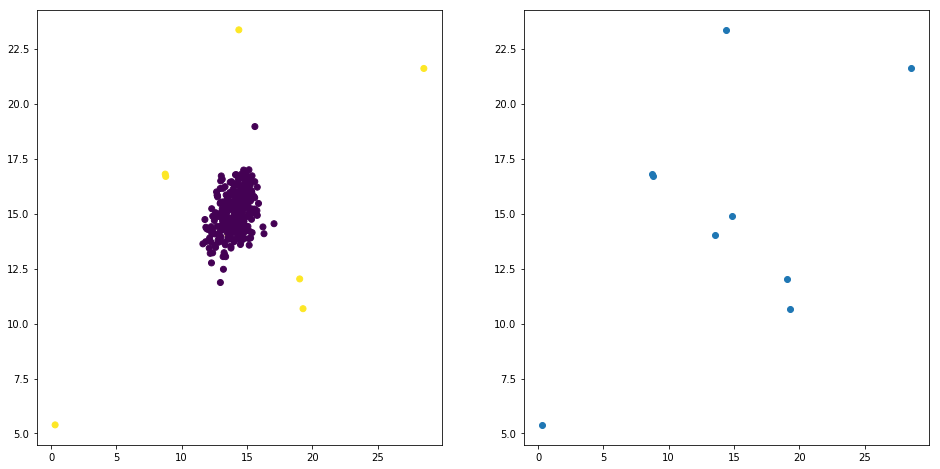

In [120]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_val[:, 0], X_val[:, 1], c=Y_val[:, 0])
plt.subplot(1, 2, 2)
plt.scatter(X_val[Y_val[:, 0] == 1, 0], X_val[Y_val[:, 0] == 1, 1])

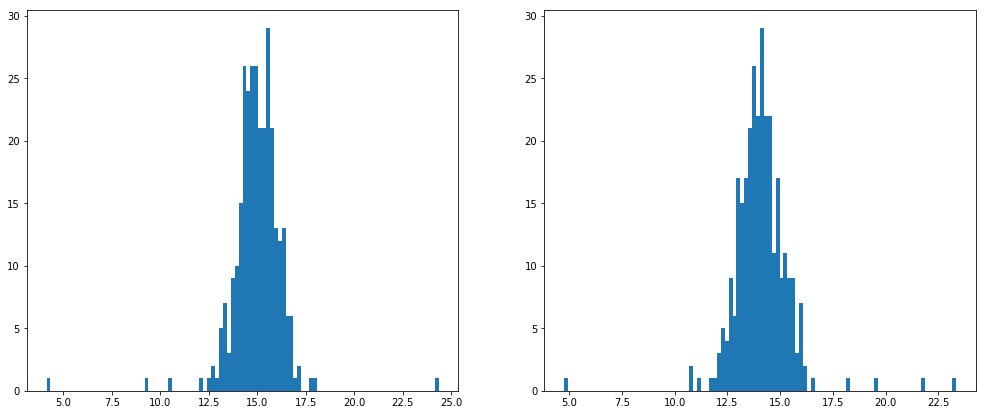

In [5]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plt.hist(X_train[:, 1], 100)
plt.subplot(1, 2, 2)
_ = plt.hist(X_train[:, 0], 100)

In [6]:
means = tf.reduce_mean(X_train, axis=0)
means.shape.as_list()

[2]

In [7]:
covariance = tf.matmul(tf.transpose(X_train - means), X_train - means) / tf.cast(tf.shape(X_train)[0], tf.float64)
covariance

<tf.Tensor: id=21, shape=(2, 2), dtype=float64, numpy=
array([[ 1.83263141, -0.22712233],
       [-0.22712233,  1.70974533]])>

In [10]:
def cal_density(x, means, covariance):
    n = tf.shape(x)[0]
    x = tf.reshape(x, (n, 1))
    means = tf.reshape(means, (n, 1))
    part1 = 1 / (tf.pow(2 * np.pi, n/2) * tf.pow(tf.linalg.det(covariance), 1/2))
    part2 = tf.exp((-1/2) * tf.transpose(x - means) @ tf.linalg.inv(covariance) @ (x - means))
    
    return part1 * part2

In [11]:
cal_density(X_val[0], means, covariance)

<tf.Tensor: id=59, shape=(1, 1), dtype=float64, numpy=array([[ 0.04183639]])>

### 矢量版

In [102]:
def cal_density_vec(X, means, covariance):
    n = tf.shape(X)[-1]
    X = tf.transpose(X)
    means = tf.reshape(means, (n, 1))
    part1 = 1 / (tf.pow(2 * np.pi, n/2) * tf.pow(tf.linalg.det(covariance), 1/2))
    part2 = tf.exp((-1/2) * tf.reduce_sum((tf.transpose(X - means) @ tf.linalg.inv(covariance)) * tf.transpose(X - means), axis=1))
    
    return part1 * part2

In [103]:
cal_density_vec(X_val[:3], means, covariance)

<tf.Tensor: id=24876, shape=(3,), dtype=float64, numpy=array([ 0.04183639,  0.08342275,  0.03732495])>

In [12]:
densities = [cal_density(x, means, covariance) for x in X_val]

In [24]:
def cal_metrics(densities, labels, epsilon):
    predicts = densities < epsilon
    precision = metrics.precision_score(labels, predicts)
    recall = metrics.recall_score(labels, predicts)
    f1 = metrics.f1_score(labels, predicts)
    
    return precision, recall, f1

In [25]:
cal_metrics(np.array(densities).reshape(-1, 1), Y_val, 0.0001)

(1.0, 0.77777777777777779, 0.87500000000000011)

In [126]:
def search_epsilon(cal_metrics, densities, labels, log_range=(-3, -5)):
    max_f1 = 0
    max_precision = 0
    max_recall = 0
    result_epsilon = 1
    for e in np.logspace(log_range[0], log_range[1], 100):
        precision, recall, f1 = cal_metrics(densities, labels, e)
#         print(e, f1)
        if f1 > max_f1:
            max_f1 = f1
            max_precision = precision
            max_recall = recall
            result_epsilon = e
            
    return result_epsilon, max_f1, max_precision, max_recall

In [127]:
epsilon, f1, precision, recall = search_epsilon(cal_metrics, np.array(densities).reshape(-1, 1), Y_val, log_range=(-3, -5))
print('best')
epsilon, f1, precision, recall

best


(0.00028480358684358022, 0.87500000000000011, 1.0, 0.77777777777777779)

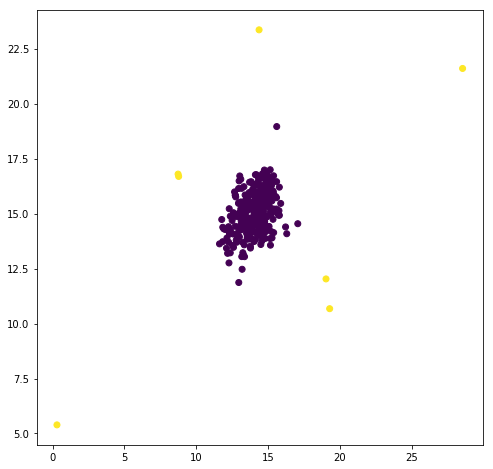

In [128]:
best_predicts = densities < epsilon
plt.figure(figsize=(8, 8))
plt.scatter(X_val[:, 0], X_val[:, 1], c=best_predicts)